# Artistic vs. Arabic MNIST 


## Introduction to challenge
We have decided to take a dataset from Kaggle ([Arabic Handwritten Characters Dataset](https://www.kaggle.com/mloey1/ahcd1)) for this challenge.   

- 16,800 characters written by 60 participants
- Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms 
- The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. 
- The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class).
- Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

__Acknowledgements__:

- A. El-Sawy, M. Loey, and H. EL-Bakry, “Arabic handwritten characters recognition using convolutional neural network,” WSEAS Transactions on Computer Research, vol. 5, pp. 11–19, 2017. 
https://doi.org/10.1007/978-3-319-48308-5_54
https://link.springer.com/chapter/10.1007/978-3-319-48308-5_54

- A. El-Sawy, H. EL-Bakry, and M. Loey, “CNN for handwritten arabic digits recognition based on lenet-5,” in Proceedings of the International Conference on Advanced Intelligent Systems and Informatics 2016, vol. 533, pp. 566–575, Springer International Publishing, 2016.
https://www.wseas.org/multimedia/journals/computerresearch/2017/a045818-075.php

- Loey, Mohamed, Ahmed El-Sawy, and Hazem El-Bakry. "Deep learning autoencoder approach for handwritten arabic digits recognition." arXiv preprint arXiv:1706.06720 (2017).
https://arxiv.org/abs/1706.06720

## Data Import
Uncomment and adapt path. 

In [ ]:
def get_kaggle_dataset():
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d 'mloey1/ahcd1'
  !mv ./*.zip /content/drive/MyDrive/DeepLearningInVisionHSLU/
  !unzip -q /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip -d /content/drive/MyDrive/DeepLearningInVisionHSLU/
  !rm /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip

## Imports

In [235]:
# Built-in imports
import os, datetime, pathlib, random, time
from glob import glob
import math
from math import ceil, floor

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
%matplotlib inline


import seaborn as sns
sns.set(color_codes=True)

import PIL
from PIL import Image
import skimage
from skimage import color, io
#from skimage import data
from skimage import transform

# Tensorflow imports
import tensorflow as tf
print(f'Tensorflow version is: {tf.version.VERSION}')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import applications, optimizers, models, losses, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.metrics import 

# Train-test-split and evaluation imports
from sklearn.model_selection import train_test_split # If required
from sklearn import metrics # classification report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

Tensorflow version is: 2.7.0
Found GPU at: /device:GPU:0


## Definitions

In [ ]:
# Divides the input array into chunks of letters
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)

# Display images by size and number of plots
def display_image(x, img_size, number_of_images):
    # Standard plot size
    plt.figure(figsize = (16, 9))
    # Takes only images 
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size)
        number_of_rows = row_calculator(number_of_images, 4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i])

# Show image by number
def show_image_by_num(img_num,array):
  img_num = img_num
  plt.imshow(test_data[img_num][:,:,0])
  plt.axis('off')

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

# Show content of dictionary
def get_dir_content(path):
  return os.listdir(path)

# load image
def load_img(path):
  return io.imread(path)

# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

## Pre-Processing


## Load data and labels

The train Images csv has 1024 columns and 13440 rows. Each column represents a pixel in an image and each row represents an individual grayscale images.

The value of each pixel varies from 0 -255.

Each column 

In [ ]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data 
path_to_data = path_project_dir.joinpath('data','train_test') / 'Arabic Handwritten Characters Dataset CSV' # because of github, this folder has been moved to the parent directory. 
# Path to images
path_to_images = path_project_dir.joinpath('data','images')

# Load train/test data
train_data = pd.read_csv(path_to_data.joinpath('csvTrainImages 13440x1024.csv'),header = None)
test_data = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None)
# Load train/test labels
train_label = pd.read_csv(path_to_data.joinpath('csvTrainLabel 13440x1.csv'),header = None)#.rename(columns={0:'label'})
test_label = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None)#.rename(columns={0:'label'})

## Check set
print('='*20)
print('Training data info')
print('='*20)
print(train_data.info(),'\n')
print('\n')
print('='*20)
print('Training labels info')
print('='*20)
print(train_label.info(),'\n')

print('='*20)
print('Test data info')
print('='*20)
print(test_data.info(),'\n')
print('\n')
print('='*20)
print('Test labels info')
print('='*20)
print(test_label.info(),'\n')
print('='*20)

Training data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB
None 



Training labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       13440 non-null  int64
dtypes: int64(1)
memory usage: 105.1 KB
None 

Test data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 26.3 MB
None 



Test labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3360 non-null   int64
dtypes: int64(1)
memory usage: 26.4 KB
None 



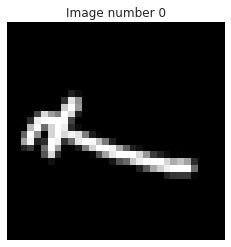

In [ ]:
for i in range(0,train_data.shape[0],32):
  show_image(
    np.reshape(
        train_data.iloc[i,:].values.astype('float32'),
        (32,32),
    ), title=f'Image number {i}'
  )
  break

The database is partitioned into two sets: 
- Training set (13,440 characters to 480 images per class) => 28 classes
- Test set (3,360 characters to 120 images per class) => 28 class

In [ ]:
print('Training:')
print(f'The shape of the df is: {train_data.shape}')
print(f'The meaning is: {train_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')
print('='*50)
print('Test:')
print(f'The shape of the df is: {test_data.shape}')
print(f'The meaning is: {test_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')

Training:
The shape of the df is: (13440, 1024)
The meaning is: 13440 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.
Test:
The shape of the df is: (3360, 1024)
The meaning is: 3360 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.


In [ ]:
# Convert images to float32
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1

test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

### Show: Sample of training images

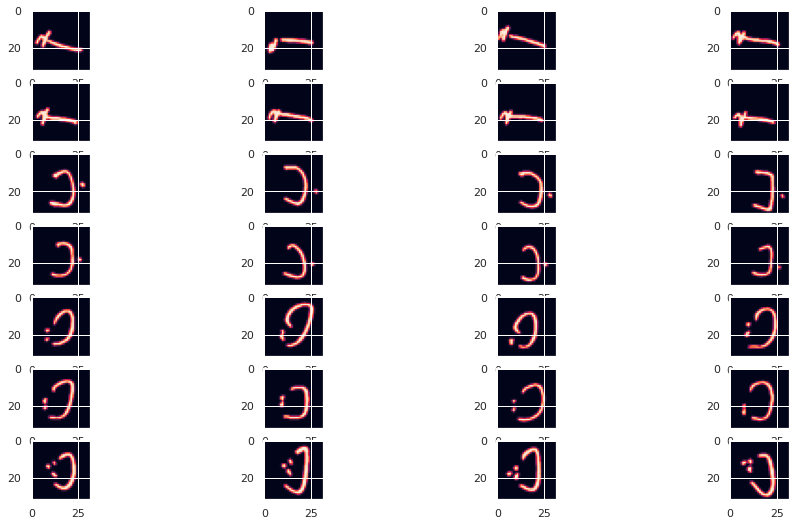

In [ ]:
# Ten images 
display_image(train_data, 32, 28)

### Show: Sample of test images

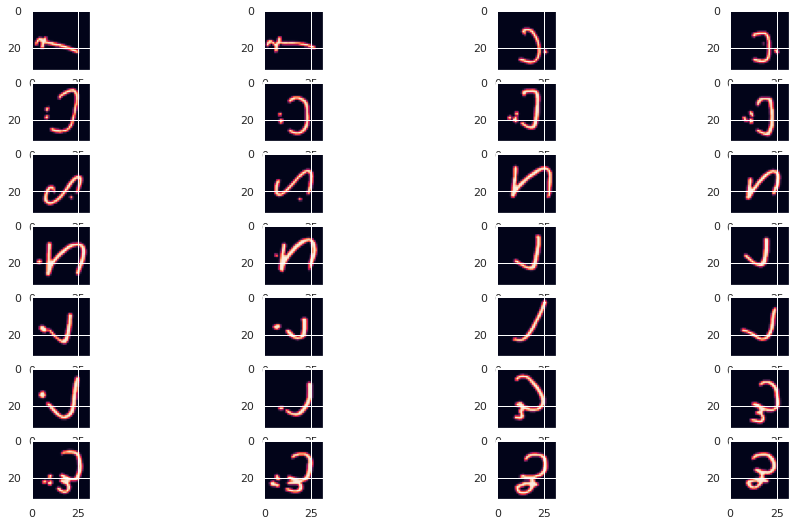

In [ ]:
display_image(test_data, 32, 28)

### Shape check

In [ ]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 1024) (13440, 1)
(3360, 1024) (3360, 1)


### Normalization, zero-centering, categorical transformations

In [ ]:
# Normalization [0,255] -> [0,1]
train_data = train_data/255
test_data = test_data/255

# Reshape to 2D -> #, height, width, rgb
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

# Categorical variable
train_label = tf.keras.utils.to_categorical(train_label,28)
test_label = tf.keras.utils.to_categorical(test_label,28)

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 32, 32, 1) (13440, 28)
(3360, 32, 32, 1) (3360, 28)


### ImageDataGenerator: 
Generate batches of tensor image data with real-time data augmentation. This data is looped over in batches. Basically, It is used to load the images in batches.

In [ ]:
validation_split = 0.2 

datagen = ImageDataGenerator(
    validation_split = validation_split,
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)


## Model 1 
[CONV2D - CONV2D - MAXPOOL - DROPOUT] [CONV2D - CONV2D - MAXPOOL - DROPOUT] [DENSE - DENSE - DROPOUT]

### Architecture

In [ ]:
with tf.device('/device:GPU:0'):
  num_classes = train_label.shape[1]
  image_size = train_data.shape[1]

  model_1 = tf.keras.Sequential()

  model_1.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', input_shape = (image_size, image_size, 1)))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Conv2D(32, (5, 5))) # padding='same'? 
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model_1.add(tf.keras.layers.Dropout(0.25))

  model_1.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Conv2D(64, (3, 3)))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # strides=(2,2)?
  model_1.add(tf.keras.layers.Dropout(0.25))

  model_1.add(tf.keras.layers.Flatten())
  model_1.add(tf.keras.layers.Dense(512))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Dense(num_classes))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Dropout(0.5))
  model_1.add(tf.keras.layers.Activation('softmax'))

  model_1.compile(
      loss = 'categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics=['accuracy']
  )

  model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                        

### Fit

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
name = 'FirstTry'
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(logdir, histogram_freq = 1)

Epoch 1/40
107/107 [==============================] - 12s 34ms/step - loss: 3.2797 - accuracy: 0.0836 - val_loss: 3.1564 - val_accuracy: 0.1358
Epoch 2/40
107/107 [==============================] - 3s 32ms/step - loss: 3.1388 - accuracy: 0.1449 - val_loss: 3.0098 - val_accuracy: 0.2019
Epoch 3/40
107/107 [==============================] - 3s 31ms/step - loss: 3.0400 - accuracy: 0.1886 - val_loss: 2.8905 - val_accuracy: 0.2612
Epoch 4/40
107/107 [==============================] - 3s 31ms/step - loss: 2.9194 - accuracy: 0.2339 - val_loss: 2.7376 - val_accuracy: 0.3300
Epoch 5/40
107/107 [==============================] - 3s 31ms/step - loss: 2.7844 - accuracy: 0.2778 - val_loss: 2.5520 - val_accuracy: 0.3900
Epoch 6/40
107/107 [==============================] - 3s 31ms/step - loss: 2.6951 - accuracy: 0.3054 - val_loss: 2.4281 - val_accuracy: 0.4438
Epoch 7/40
107/107 [==============================] - 3s 31ms/step - loss: 2.6259 - accuracy: 0.3249 - val_loss: 2.3140 - val_accuracy: 0.470

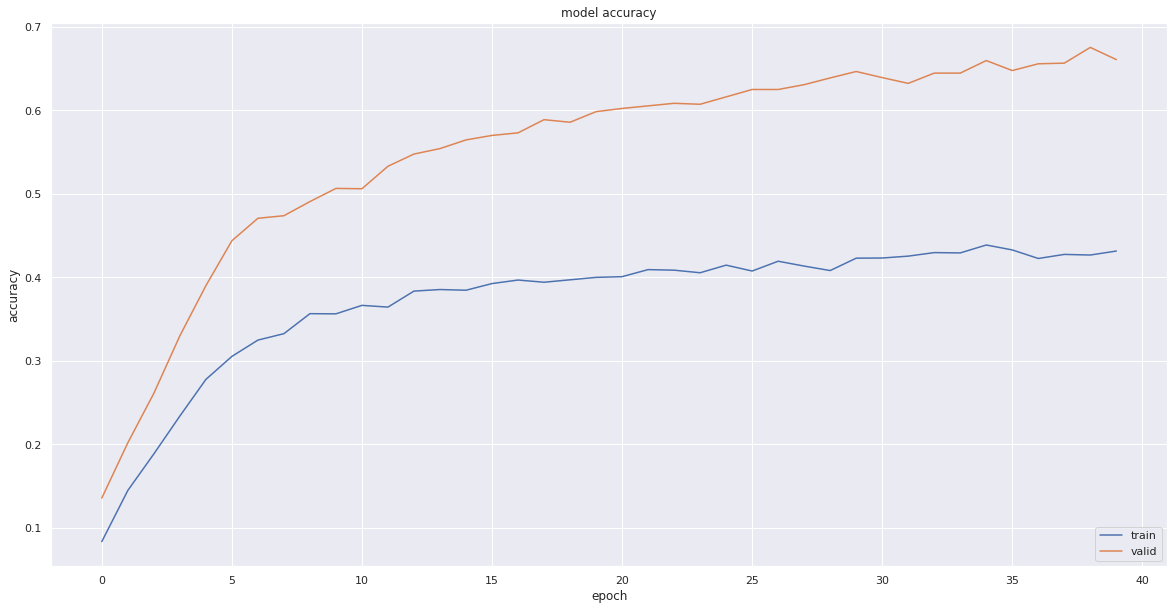

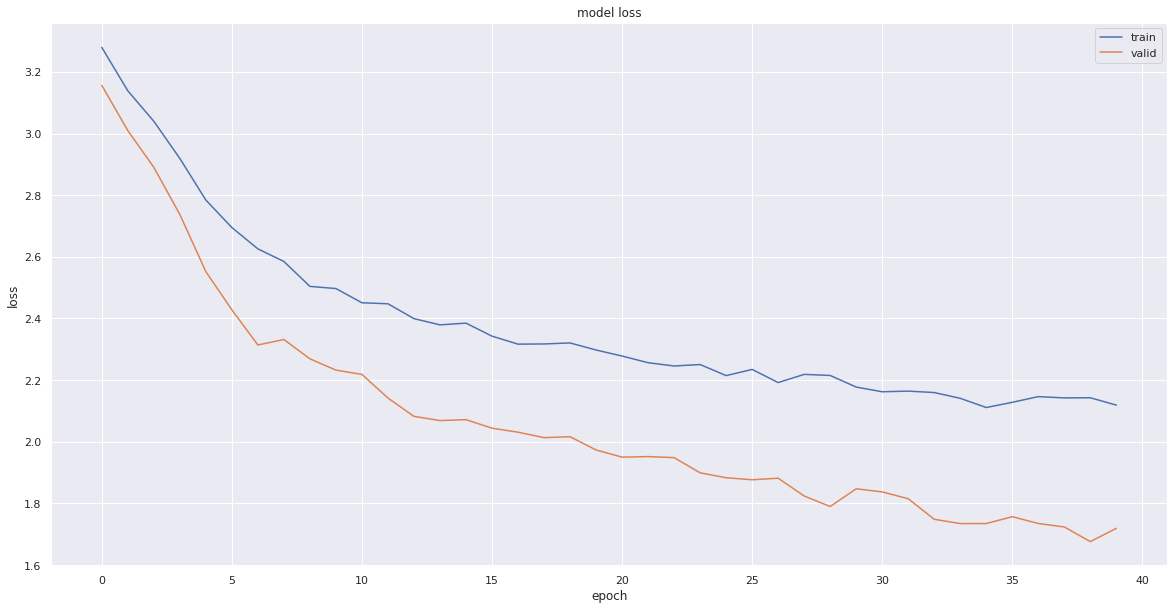

In [ ]:
epochs = 40
batch_size = 100

train_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

validation_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

datagen.fit(train_data)
history = model_1.fit(
    train_generator,
    steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
    validation_data = validation_generator,
    validation_steps = len(train_data) * validation_split // batch_size,
    epochs = epochs, 
    #callbacks = [tensorboard],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
#%tensorboard --logdir logs

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 1.1360 - accuracy: 0.7979
test loss, test acc: [1.1359851360321045, 0.7979166507720947]
{'loss': 1.1359851360321045, 'accuracy': 0.7979166507720947}


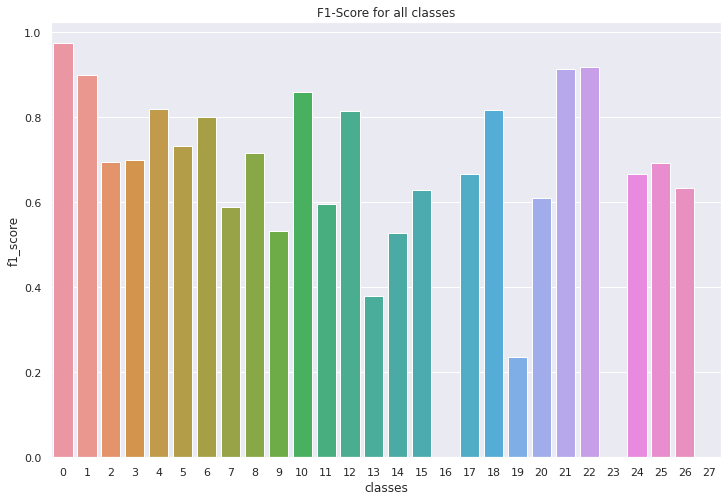

In [ ]:
print("Evaluate on test data")
result = model_1.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_1.metrics_names, result)))

# Save model
model_1.save(path_project_dir.joinpath('models','model_1.h5'))

# Create predictions
y_pred = np.around(model_1.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics1 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics1, 
    columns = list(metrics1.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 2 

### Architecture
[CONV2D - MAXPOOL] [CONV2D - MAXPOOL] [DENSE - DROPOUT - DENSE]

In [ ]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_2.add(Flatten())  
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 activation_8 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 4s 35ms/step - loss: 3.3255 - accuracy: 0.0499 - val_loss: 3.3110 - val_accuracy: 0.0604
Epoch 2/150
107/107 [==============================] - 3s 31ms/step - loss: 3.2915 - accuracy: 0.0653 - val_loss: 3.2445 - val_accuracy: 0.0892
Epoch 3/150
107/107 [==============================] - 3s 32ms/step - loss: 3.2022 - accuracy: 0.0875 - val_loss: 3.0996 - val_accuracy: 0.1296
Epoch 4/150
107/107 [==============================] - 3s 32ms/step - loss: 3.0515 - accuracy: 0.1302 - val_loss: 2.9251 - val_accuracy: 0.1642
Epoch 5/150
107/107 [==============================] - 3s 32ms/step - loss: 2.9107 - accuracy: 0.1549 - val_loss: 2.7558 - val_accuracy: 0.2135
Epoch 6/150
107/107 [==============================] - 3s 32ms/step - loss: 2.7583 - accuracy: 0.1981 - val_loss: 2.6278 - val_accuracy: 0.2369
Epoch 7/150
107/107 [==============================] - 3s 32ms/step - loss: 2.6279 - accuracy: 0.2209 - val_loss: 2.4725 - val_accuracy:

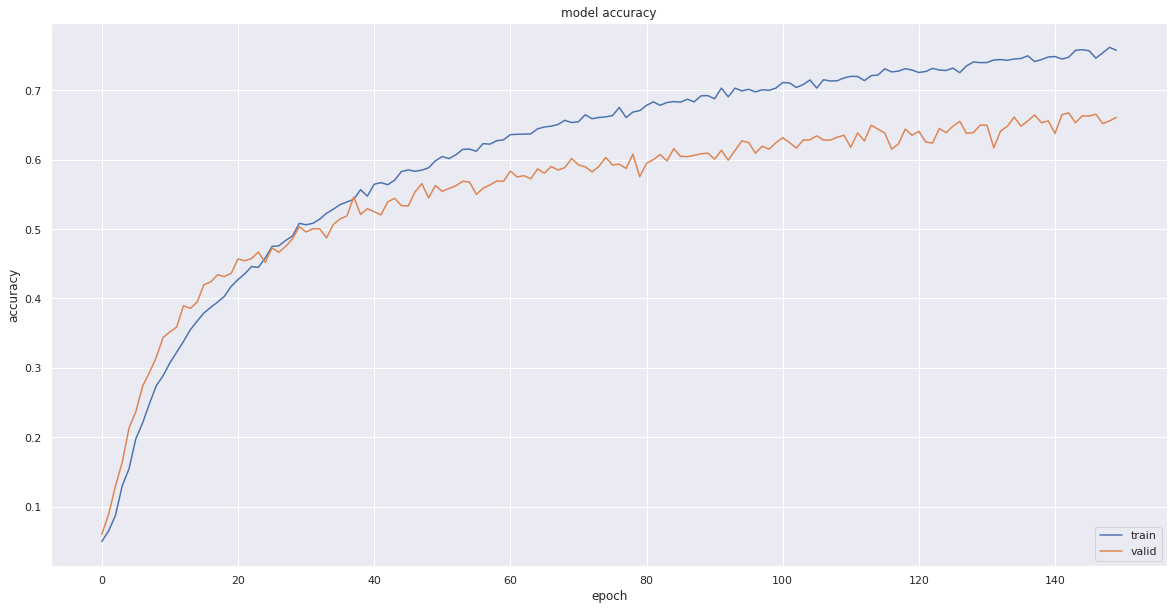

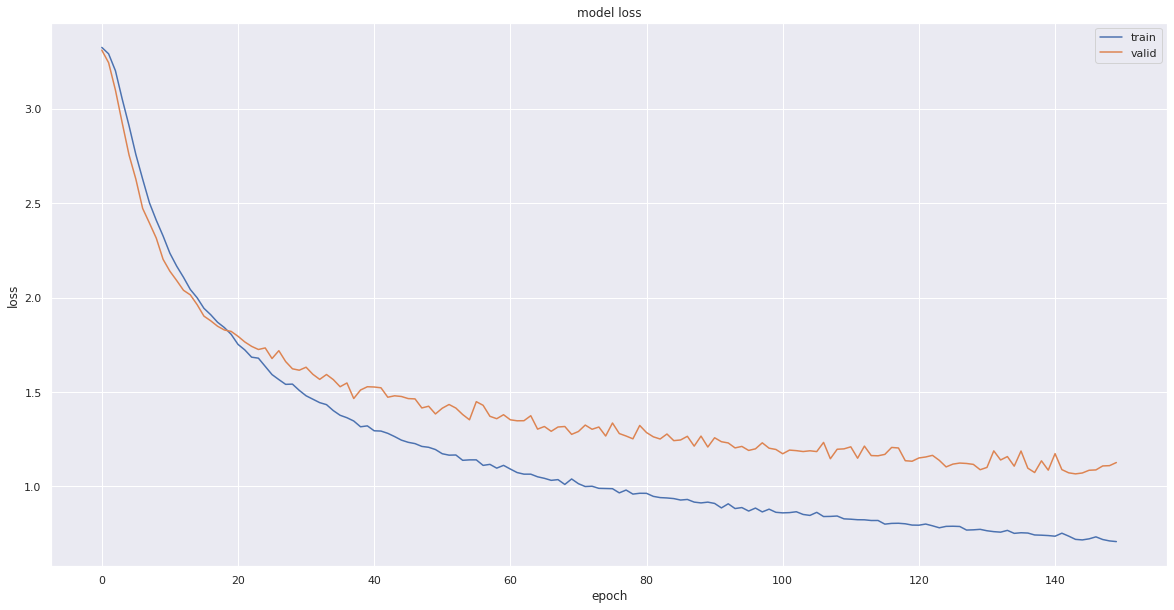

In [ ]:
with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_2.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 0.4298 - accuracy: 0.8622
test loss, test acc: [0.4298064708709717, 0.8622024059295654]
{'loss': 0.4298064708709717, 'accuracy': 0.8622024059295654}


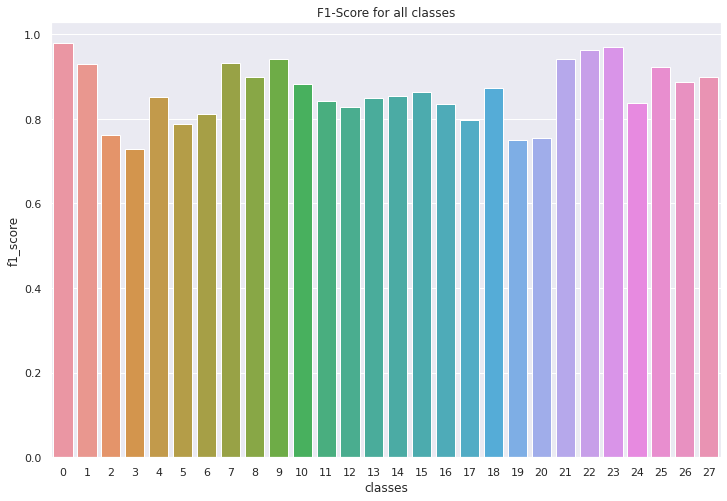

In [ ]:
print("Evaluate on test data")
result = model_2.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_2.metrics_names, result)))

# Save model
model_2.save(path_project_dir.joinpath('models','model_2.h5'))

# Create predictions
y_pred = np.around(model_2.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics2 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics2, 
    columns = list(metrics2.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 3 Modifications increasing `learning_rate`. 
The learning rate of our model was not declining fast enough, therefore we have adapted our learning rate, we decrease it by a factor of 10. 

### Architecture

In [ ]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_3.add(Flatten())  
model_3.add(Dense(64))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 activation_17 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 activation_18 (Activation)  (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 4s 33ms/step - loss: 3.0829 - accuracy: 0.1063 - val_loss: 2.6018 - val_accuracy: 0.2558
Epoch 2/150
107/107 [==============================] - 3s 32ms/step - loss: 2.4037 - accuracy: 0.2594 - val_loss: 1.9847 - val_accuracy: 0.3662
Epoch 3/150
107/107 [==============================] - 3s 31ms/step - loss: 1.9117 - accuracy: 0.3691 - val_loss: 1.6989 - val_accuracy: 0.4508
Epoch 4/150
107/107 [==============================] - 3s 32ms/step - loss: 1.6074 - accuracy: 0.4573 - val_loss: 1.5516 - val_accuracy: 0.5012
Epoch 5/150
107/107 [==============================] - 3s 32ms/step - loss: 1.4421 - accuracy: 0.5132 - val_loss: 1.4757 - val_accuracy: 0.5323
Epoch 6/150
107/107 [==============================] - 3s 32ms/step - loss: 1.3289 - accuracy: 0.5417 - val_loss: 1.3904 - val_accuracy: 0.5477
Epoch 7/150
107/107 [==============================] - 3s 32ms/step - loss: 1.2249 - accuracy: 0.5785 - val_loss: 1.3332 - val_accuracy:

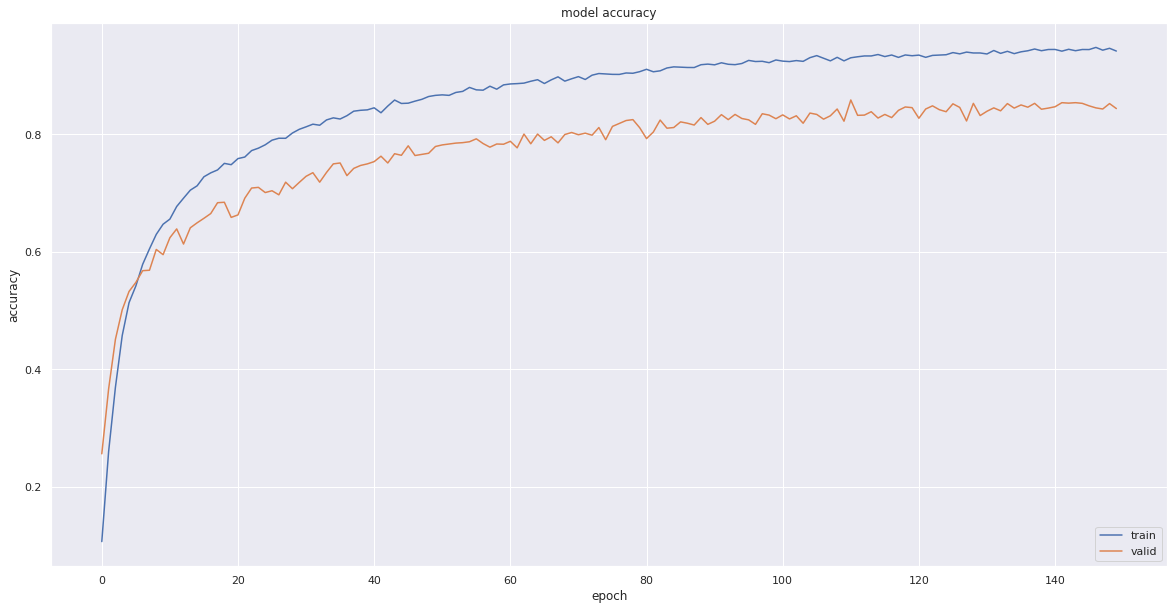

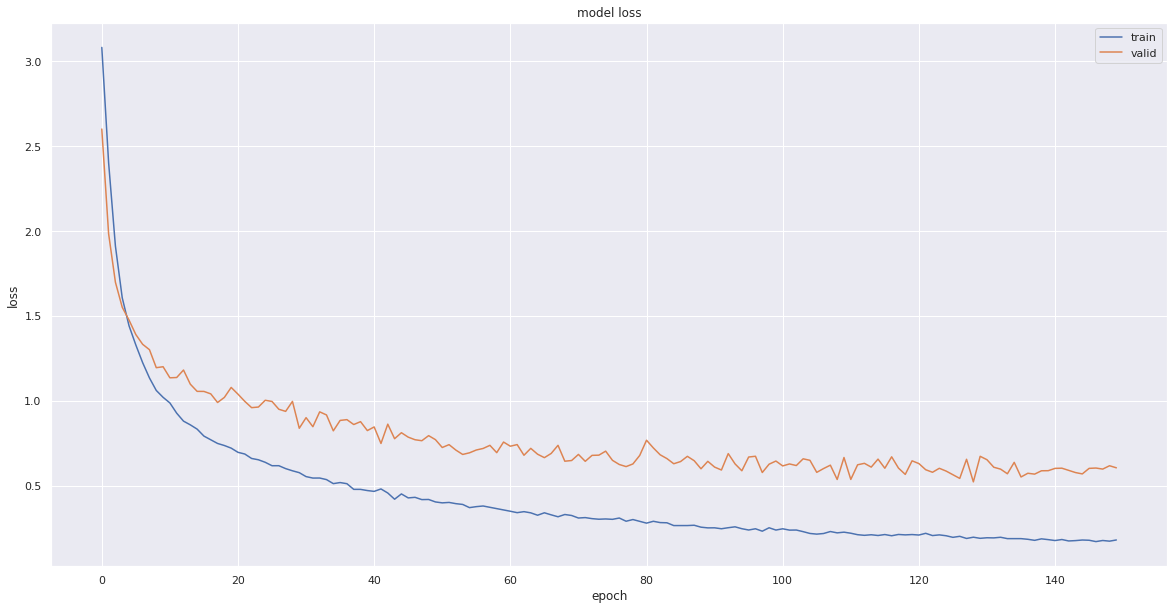

In [ ]:
with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_3.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 3ms/step - loss: 0.1910 - accuracy: 0.9580
test loss, test acc: [0.19096197187900543, 0.9580357074737549]
{'loss': 0.19096197187900543, 'accuracy': 0.9580357074737549}


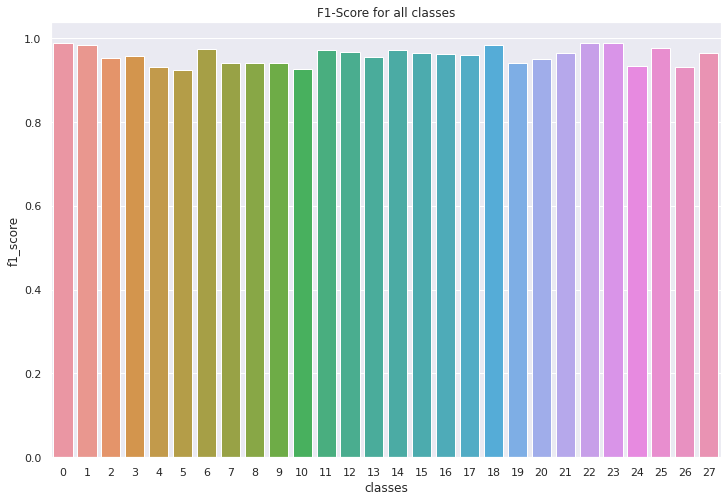

In [ ]:
print("Evaluate on test data")
result = model_3.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_3.metrics_names, result)))

# Save model
model_3.save(path_project_dir.joinpath('models','model_3.h5'))

# Create predictions
y_pred = np.around(model_3.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics3 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics3, 
    columns = list(metrics3.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 4 Modification of CONV2D

### Architecture

In [31]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_4 = tf.keras.Sequential()
model_4.add(Conv2D(64, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_4.add(Flatten())  
model_4.add(Dense(64))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes))
model_4.add(Activation('softmax'))

model_4.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 activation_5 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 activation_6 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 6s 47ms/step - loss: 3.1861 - accuracy: 0.0848 - val_loss: 2.7285 - val_accuracy: 0.2150
Epoch 2/150
107/107 [==============================] - 5s 45ms/step - loss: 2.5133 - accuracy: 0.2338 - val_loss: 2.0536 - val_accuracy: 0.3623
Epoch 3/150
107/107 [==============================] - 5s 47ms/step - loss: 1.9969 - accuracy: 0.3561 - val_loss: 1.8270 - val_accuracy: 0.4112
Epoch 4/150
107/107 [==============================] - 5s 46ms/step - loss: 1.7248 - accuracy: 0.4324 - val_loss: 1.7305 - val_accuracy: 0.4427
Epoch 5/150
107/107 [==============================] - 5s 45ms/step - loss: 1.5039 - accuracy: 0.4961 - val_loss: 1.5142 - val_accuracy: 0.4958
Epoch 6/150
107/107 [==============================] - 5s 45ms/step - loss: 1.3526 - accuracy: 0.5419 - val_loss: 1.4684 - val_accuracy: 0.5204
Epoch 7/150
107/107 [==============================] - 5s 46ms/step - loss: 1.2446 - accuracy: 0.5729 - val_loss: 1.3610 - val_accuracy:

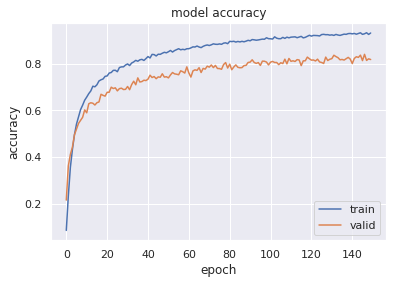

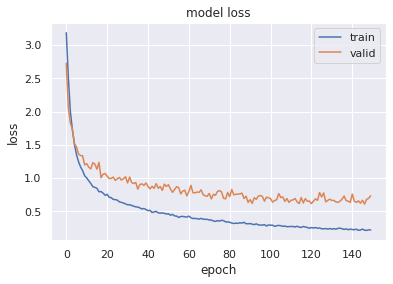

In [32]:
device_name = tf.test.gpu_device_name()

with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_4.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 0.2009 - accuracy: 0.9521
test loss, test acc: [0.20088140666484833, 0.9520833492279053]
{'loss': 0.20088140666484833, 'accuracy': 0.9520833492279053}


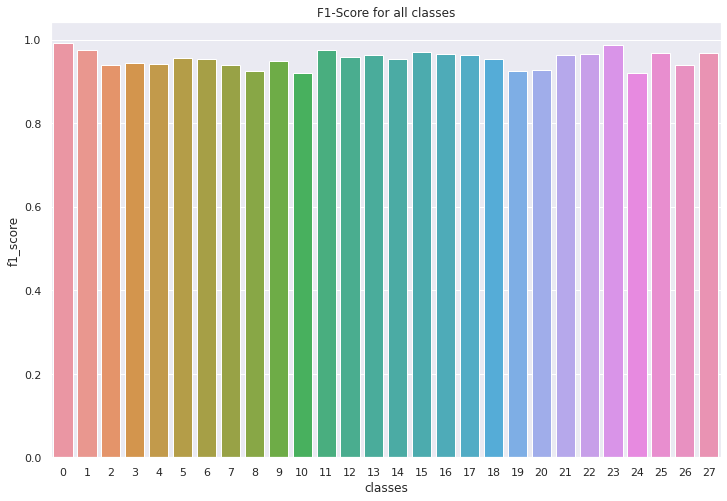

In [33]:
print("Evaluate on test data")
result = model_4.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_4.metrics_names, result)))

# Save model
#model_4.save(path_project_dir.joinpath('models','model_4.h5'))

# Create predictions
y_pred = np.around(model_4.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics4 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics4, 
    columns = list(metrics4.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Neural Transfer

In [214]:
%tensorflow_version 1.x
tf.compat.v1.enable_eager_execution()

TensorFlow is already loaded. Please restart the runtime to change versions.


In [215]:
# Path to images
path_to_images = path_project_dir.joinpath('data','images')

# arabic labels 
arabic_labels = {1: 'Alif', 2: 'Ayeen', 3: 'Baa', 4: 'Daal', 5: 'Faa', 6: 'Ghaeen', 7: 'Haa', 8: 'Jeem', 9: 'Kaaf', 10: 'Khaa', 11: 'Laam', 
                 12: 'Meem', 13: 'Nuun', 14: 'Qouf', 15: 'Raa', 16: 'Saa', 17: 'Seen', 18: 'Sheen', 19: "Su'ad", 20: 'Taa', 21: 'Tuaa', 
                 22: 'Waoo', 23: 'Yaa', 24: 'Zaal', 25: 'Zazza', 26: "Zu'ad", 27: 'Zua', 28: 'huu'}

# approximation - alphabet to arabic
alphabet_to_arabic = {'a': 'Alif','b': 'Baa','d':'Daal','f': 'Faa','r': 'Ghaeen','h': 'Haa','j': 'Jeem','k': 'Kaaf','l': 'Laam',
                      'm': 'Meem','n': 'Nuun','q': 'Qouf','r': 'Raa','s': 'Saa','t': 'Taa','u': 'Waoo','i': 'Yaa','z': 'Zaal'}
            
# approximation - arabib to alphabet
arabic_to_alphabet = {v:k for k,v in alphabet_to_arabic.items()}

In [216]:
# Images
train_imgs = pd.read_csv(path_to_data.joinpath('csvTrainImages 13440x1024.csv'),header = None).values.astype('float32').reshape(-1,32,32,1) 
test_imgs = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None).values.astype('float32').reshape(-1,32,32,1) 
# Labels
train_labels = pd.read_csv(path_to_data.joinpath('csvTrainLabel 13440x1.csv'),header = None)
test_labels = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None)

df_train = train_labels.rename(columns={0:'label'})
df_test = test_labels.rename(columns={0:'label'})

df_test

,label
0,1
1,1
2,2
3,2
4,3
...,...
3355,26
3356,27
3357,27
3358,28


In [217]:
def get_img(img_num, array = test_imgs):
  return array[img_num][:,:,0]

df_train = (df_train
            .assign(name = lambda x: x.label.apply(arabic_labels.get))
            .assign(equivalent = lambda x: x.name.apply(arabic_to_alphabet.get))
            .assign(img_array = lambda x: x.label.apply(get_img))
)
df_test = (df_test
            .assign(name = lambda x: x.label.apply(arabic_labels.get))
            .assign(equivalent = lambda x: x.name.apply(arabic_to_alphabet.get))
            .assign(img_array = lambda x: x.label.apply(get_img))
)

df_test.head()

,label,name,equivalent,img_array
0,1,Alif,a,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,Alif,a,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,Ayeen,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,2,Ayeen,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,3,Baa,b,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Image array input "Alif" equivalent to "a"


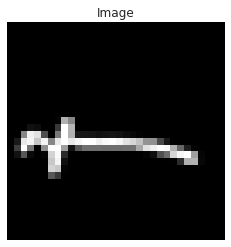

Prediction is a


In [218]:
# Create a sample img
test_sample = df_test[df_test.label == 1].sample(1)
print(f'Image array input "{test_sample.name.values[0]}" equivalent to "{test_sample.equivalent.values[0]}"')
test_img = test_sample.img_array.values[0]

# Show this image
show_image(test_img)

# Show prediction
to_predict = test_img.reshape(-1,32,32,1)
prediction = np.argmax(model_4.predict(to_predict))
#to_predict.shape
print(f'Prediction is {arabic_to_alphabet[arabic_labels[prediction+1]]}')

In [287]:
prediction_value = arabic_to_alphabet[arabic_labels[prediction+1]]

content_path = {
  item.split('/')[-1]:item for item in glob(str(path_project_dir.joinpath('data','images','content'))+'*/*/*')
}
#content_path = glob(str(path_project_dir.joinpath('data','images','content'))+'*/*/*')
style_path ={ 
  item.split('/')[-1]:item for item in glob(str(path_project_dir.joinpath('data','images','style'))+'*/*/*')
}

for letter in content_path.keys():
  if prediction_value in letter[0]:
    print(letter)
#    content = content_path[letter]
#    style = style_path[letter]

SyntaxError: ignored

In [220]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

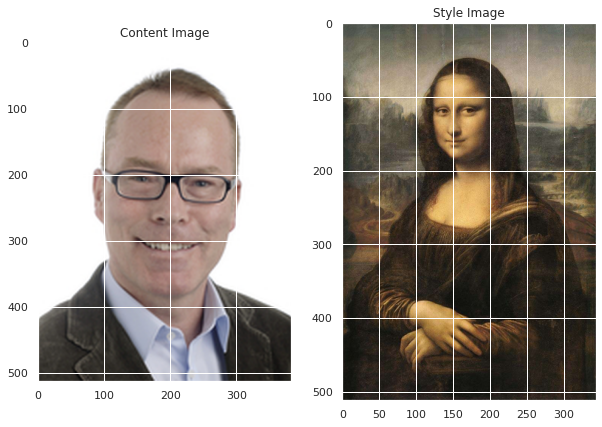

In [221]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [222]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [223]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [224]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [225]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [226]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [227]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [228]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [229]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [230]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [233]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.compat.v1.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

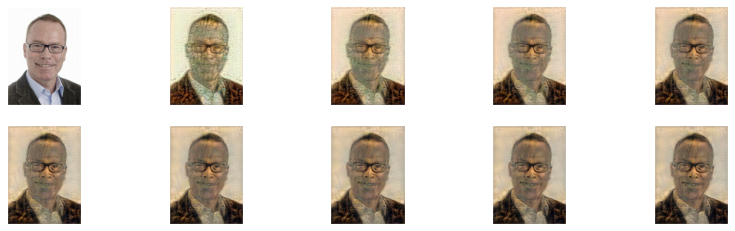

In [236]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

In [237]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

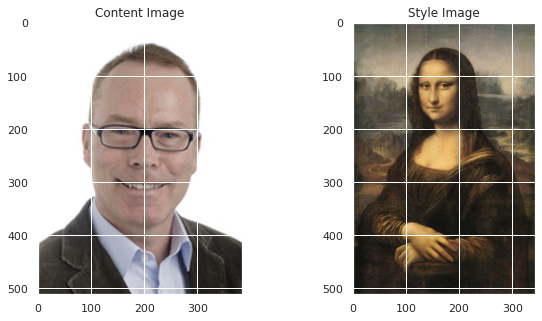

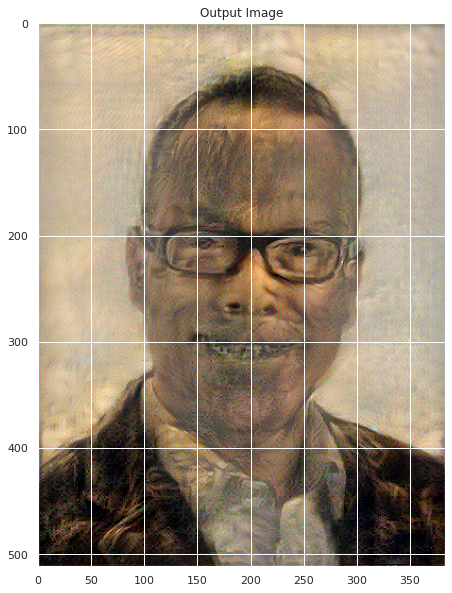

In [238]:
show_results(best, content_path, style_path)